# <center><font color='OrangeRed'>Анализ рынка общественного питания в Москве</font></center>

Мною будет подготовлен аналитическое исследование рынка общественного питания в Москве для привлечения инвестора. 

*Исходные данные* для моего исследования:
 - датафрейм rest_data с информацией об участниках рынка
 
В него входит следующая информация:
 - **id** - идентификатор места;
 - **object_name** - название заведения;
 - **chain** - является-ли сетевым рестораном;
 - **object_type** - тип заведения;
 - **address** - адрес;
 - **number** - количество посадочных мест.
 
Исследование будет построено из следующих *этапов*:

   1. [Предобработка данных](#obzor)
   2. [Анализ данных](#analiz)
   3. [Вывод по результатам исследования](#vyvod)
   4. [Презентация](#prezent)

# <a id="obzor"></a><font style="background-color: Cyan; color=black">1. Предобработка данных</font> #

In [1]:
! pip install openpyxl
! pip install xlwt

In [2]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xlwt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 10)})
from io import BytesIO

import plotly.express as px
from plotly import graph_objects as go
from scipy import stats

pd.options.display.max_colwidth = 100000
pd.options.display.max_rows = 600

In [3]:
try:
    data = pd.read_csv(r'C:\rest_data.csv')
except FileNotFoundError as e:
    print(e)
    data = pd.read_csv('/datasets/rest_data.csv')
data.head()

In [4]:
data.info()

In [5]:
display(f'Количество дубликатов - {data.duplicated().sum()}')

In [6]:
display('Количество различных заведений - {}, признаков - {}'.format(*data.shape))

Все данные имеют корректый формат, дубликатов нет.

# <a id="analiz"></a><font style="background-color: Cyan; color=black">2. Анализ данных</font> #

<font color='blue'>Соотношение **видов** объектов общественного питания</font>

In [7]:
sns.set_palette('Set1')
sns.set_style('whitegrid')

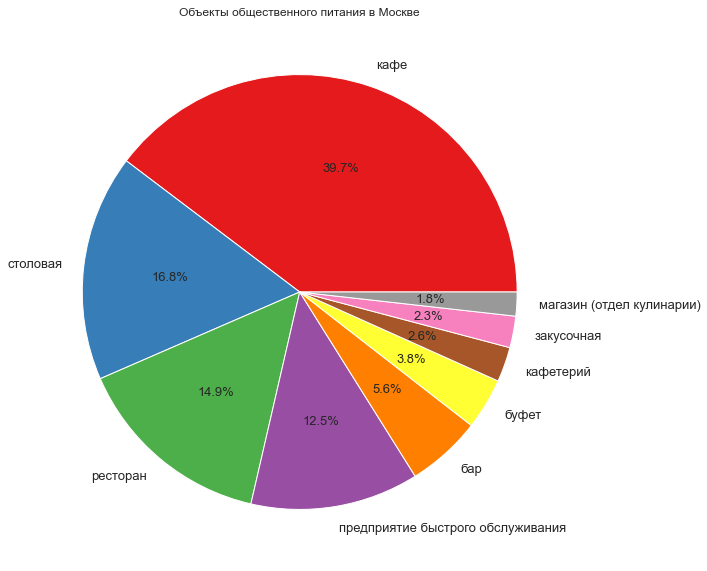

In [8]:
type_freq = data['object_type'].value_counts().to_frame()
type_freq.columns = ['Количество бъектов']
type_freq.plot(kind='pie', subplots=True, legend='', autopct='%1.1f%%', textprops={'fontsize': 13})
plt.axis('off')
plt.title('Объекты общественного питания в Москве')
plt.show()

На графике уже видно, что **кафе** в Москве больше всего. Для удобства отображу данные методом countplot

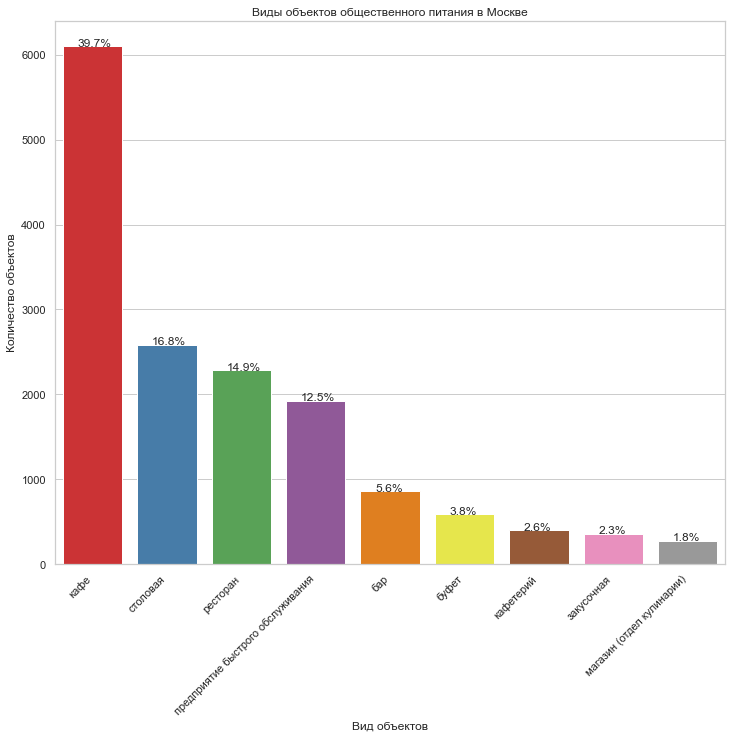

In [9]:
chart = sns.countplot(x='object_type', data=data, order=type_freq.index.tolist())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Вид объектов')
plt.ylabel('Количество объектов')
plt.title('Виды объектов общественного питания в Москве')

for p in chart.patches:
    chart.annotate('{:.1f}%'.format(p.get_height()/len(data)*100),(p.get_x()+0.2, p.get_height()+2))
plt.show()

**Вывод**

- Чуть менее 40% от всех объектов общественного питания в Москве - кафе;
- Столовые, рестораны и предприятия быстрого обсуживания - 17%, 15% и 13% соответсвтенно;
- Меньше всего в Москве представлены *отделы кулинарии*.

<font color='blue'>Соотношение **сетевых и несетевых** объектов общественного питания</font>

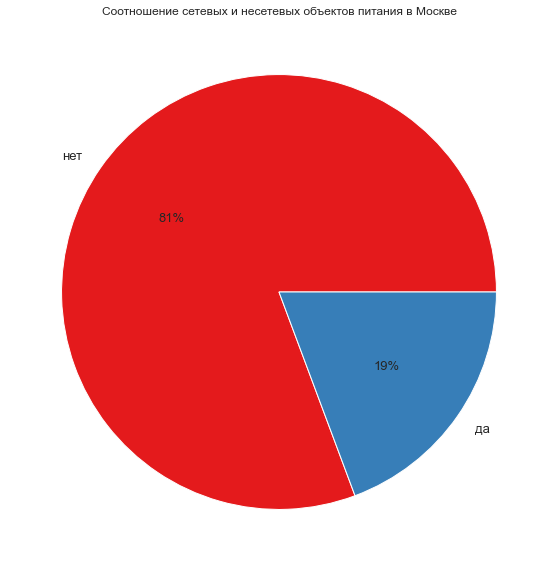

In [10]:
data['chain'].value_counts().plot(kind='pie', subplots=True, legend='', autopct='%1.0f%%', textprops={'fontsize': 13})
plt.axis('off')
plt.title('Cоотношение сетевых и несетевых объектов питания в Москве')
plt.show()

**Вывод**

- 81% - *несетевые*; 
- 19% - *сетевые*.

<font color='blue'>Для какового вида общественного питания характерно **сетевое распространение**</font>

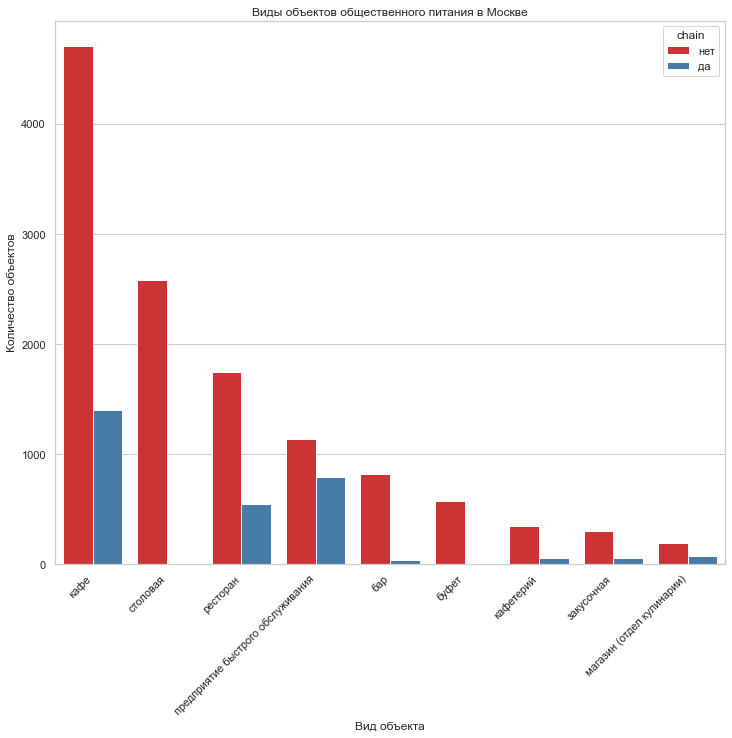

In [11]:
chart = sns.countplot(x='object_type', hue='chain', data=data, order=type_freq.index.tolist())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Вид объекта')
plt.ylabel('Количество объектов')
plt.title('Виды объектов общественного питания в Москве')
plt.show()

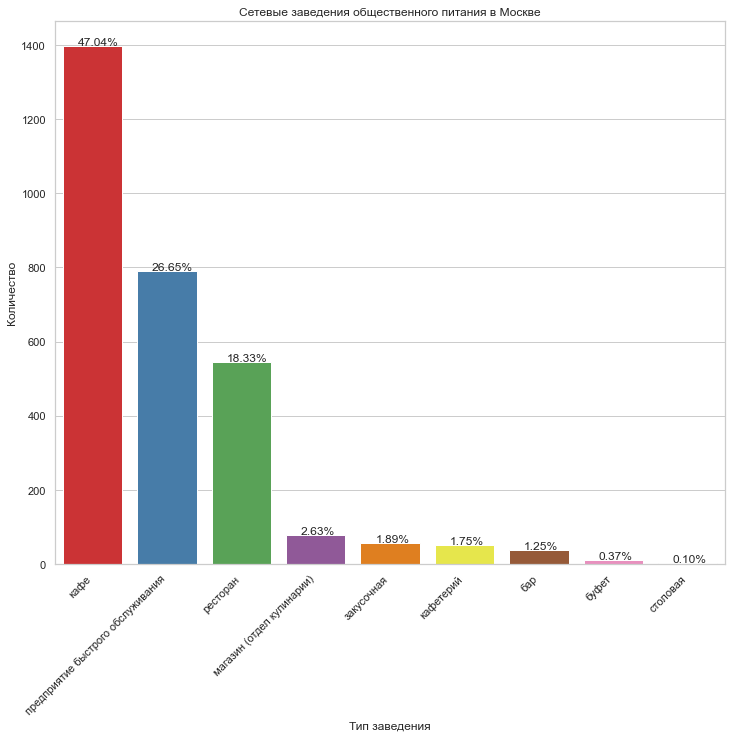

In [12]:
chain_objects = data.query('chain=="да"')['object_type'].value_counts().to_frame()
chart = sns.countplot(x='object_type', data=data.query('chain=="да"'), order=chain_objects.index.tolist())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Тип заведения')
plt.ylabel('Количество')
plt.title('Сетевые заведения общественного питания в Москве')

for p in chart.patches:
    chart.annotate('{:.2f}%'.format(p.get_height()/len(data.query('chain=="да"'))*100),(p.get_x()+0.2, p.get_height()+2))
plt.show()

**Вывод**

- *47.04%* от всех сетевых объектов - кафе;
- Предприятия быстрого обслуживания и рестораны тоже достаточно популярны в сетевом распространении;
- Меньше всего в сетевом сегменте представлены буфет и столовая.

In [13]:
setev = data.groupby(['object_type']).agg({'id': 'count' }).sort_values(by = ['object_type'], ascending = True).reset_index()
setev.columns = ['object_type','alltype_count']
setev

In [14]:
only_set = (data.query('chain == "да"')
        .groupby(['object_type'])
        .agg({'id': 'count' })
        .sort_values(by = ['object_type'], ascending = True)
        .reset_index())
only_set.columns = ['object_type','group_count']
only_set

In [15]:
setev = setev.merge(only_set, on = 'object_type')
setev['group_part'] = (setev['group_count']/setev['alltype_count']*100).round(2)
setev = setev.sort_values(by = 'group_part', ascending = False)
setev

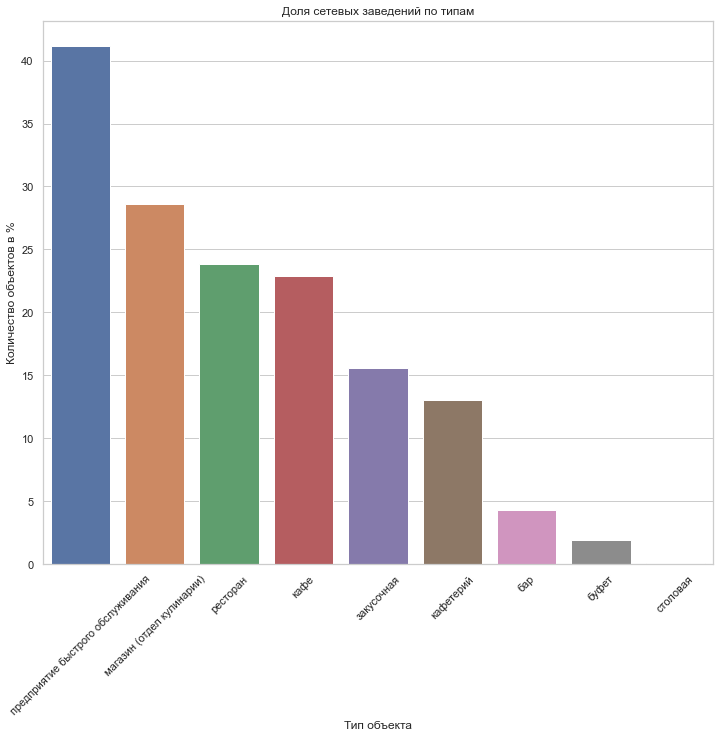

In [16]:
sns.set(style="whitegrid")
ax = sns.barplot(x='object_type', y = 'group_part',  data=setev)
ax.set_ylabel('Количество объектов в %')
ax.set_xlabel('Тип объекта')
ax.set_title('Доля сетевых заведений по типам')
plt.xticks(rotation=45)
plt.show()

В таком случае лидерами будут - предприятия быстрого обслуживания, кулинария, рестораны. 

<font color='blue'>Что характерно для сетевых объектов: **много заведений и меньше посадочных мест** или **мало заведений и больше посадочных мест**</font>

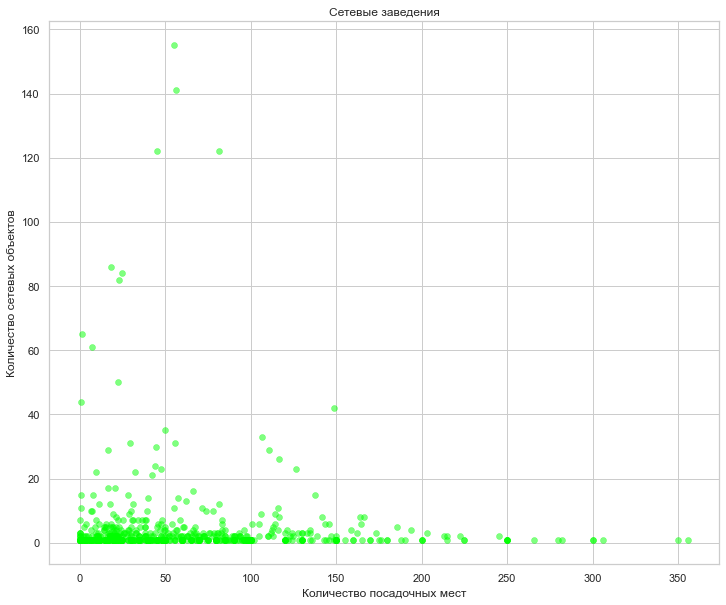

In [17]:
chain_objects = data.query('chain=="да"')
chain_objects = chain_objects.groupby('object_name').agg({'number':['count', 'mean']})
chain_objects.columns = ['quantity', 'sits_number']

sns.scatterplot(y='quantity', x='sits_number', data=chain_objects, edgecolor=None, alpha=0.5, color='lime')
plt.ylabel('Количество сетевых объектов')
plt.xlabel('Количество посадочных мест')
plt.title("Сетевые заведения")
plt.show()

**Вывод**

Сетевые объекты чаще всего имеют до *20* объектов в городе, до *150* посадочных мест.

<font color='blue'>**Среднее количество** посадочных мест</font>

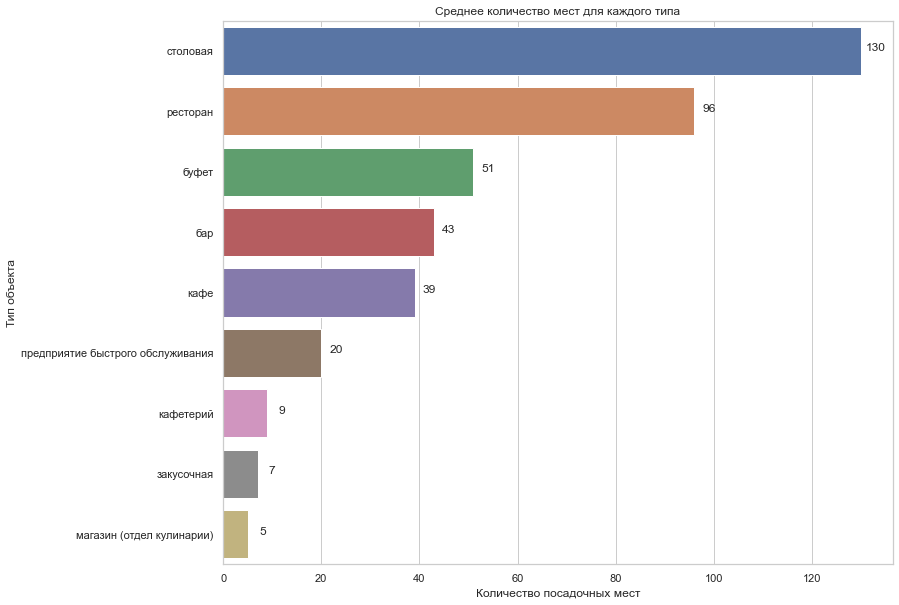

In [18]:
types = data.groupby('object_type', as_index=False)['number'].mean().sort_values(by='number', ascending=False)
types['number'] = types['number'].astype(int)

chart = sns.barplot(y='object_type', x='number', data=types)
plt.ylabel('Тип объекта')
plt.xlabel('Количество посадочных мест')
plt.title('Среднее количество мест для каждого типа')

for p in chart.patches:
    width = p.get_width()
    chart.text(width + 3,
            p.get_y()+p.get_height()/2.,
            '{:1.0f}'.format(width),
            ha="center")
plt.show()

**Вывод**

- Больше всего посадочных мест *до 130* - в столовых;
- Следом идут рестораны - *до 96*;
- Меньше всего посадочных мест *от 5 до 10* - в кафетериях.

<font color='blue'>**Информация об улице**</font>

In [19]:
street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']
def street_finder(address):
    for address_part in address.split(', '):
        for street_type in street_types:
            if address_part.lower().find(street_type)!= -1:
                return address_part
            
data['street'] = data['address'].apply(street_finder)
data_with_streets = data[~(data['street'].isnull())]
data_with_streets.head(5)

Таким образом, я выделил все "явные" названия улиц из списка 'street_types'

<font color='blue'>**Топ-10 улиц** по количеству объектов общественного питания</font>

По моим наблюдениям чаще всего название улицы идет после города.

In [20]:
def get_street(address):
    return address.split(",")[1].strip()

data['street'] = data['address'].apply(get_street)
data.head()

<font color='blue'>**График Топ-10 улиц** по количеству объектов общественного питания</font>

Реестр объектов недвижимости города Москвы с нужной информацией - https://data.mos.ru/datasets/60562

Ссылка на файл - https://yadi.sk/d/OmPdaFOpCDQtjg

In [21]:
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
full_moscow_data = pd.read_excel(r'C:\\streets.xlsx', sheet_name = 'Sheet0')

In [22]:
full_moscow_data.head()

In [23]:
moscow_data = full_moscow_data[['ADDRESS', 'P5']]
moscow_data.columns = ['address', 'district']
moscow_data.info()

Во внешних данных есть информация о *282000 адресах*, но есть пропуски в районах.
Присоединю к таблице data доступные данные о мунициапльных районах в moscow_data с помощью merge по ключу address.

In [24]:
full_data = data.merge(moscow_data, on='address', how='left')

In [25]:
full_data.info()

In [26]:
len(full_data[full_data['district'].isna()])/len(data)

Не для всех адресов получилось восстановить район.

Но таких адресов менее 1%, пропуски не изменяю.

In [27]:
full_data.head()

Сколько заведений работает на каждой улице в каждом районе

In [28]:
n_by_street_district = full_data.groupby(['street', 'district'])\
                           .agg({'number': 'count'})\
                           .sort_values(by='number', ascending=False).reset_index()
n_by_street_district[n_by_street_district['street'] == 'город Зеленоград']

In [29]:
n_by_street_district[n_by_street_district['district'] == 'муниципальный округ Марьина Роща']

При построении графика Топ-10 улиц по количеству объектов общественного питания я не буду учитывать Зеленоград - хоть и относится к Москве, но находится в сильной удаленности от нее. И для анализа общепита Москвы он не подходит.

In [30]:
top10_streets = n_by_street_district.query('street !="город Зеленоград"')\
                                    .groupby('street')['number'].sum()\
                                    .sort_values(ascending=False)[:10].to_frame().reset_index()

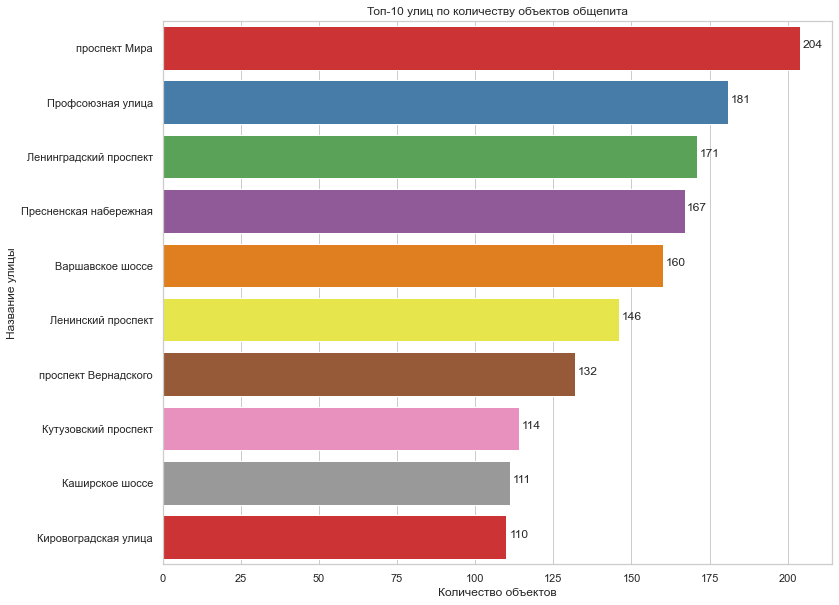

In [31]:
chart = sns.barplot(y='street', x='number', data=top10_streets, palette='Set1')
plt.xlabel('Количество объектов')
plt.ylabel('Название улицы')
plt.title('Топ-10 улиц по количеству объектов общепита')

for p in chart.patches:
    width = p.get_width()
    chart.text(width + 4,
            p.get_y()+p.get_height()/2.,
            '{:1.0f}'.format(width),
            ha="center")
plt.show()

**Вывод**

Больше всего заведений находится на важнейших транспортных магистралях Москвы - проспект Мира, Профсоюзная улица, Лениградский проспект, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе - в центре на Пресненской набережной и на улице Кировоградской.

Выберу названия Топ-10 улиц с наибольшим количеством объектов общепита. Затем уточню информацию из таблицы, сколько  улиц находится в кадом районе для топ-10 улиц с наибольшим коичеством заведений. Для каждой улицы выберу все районы, где открыты заведения общественного питания.

In [32]:
top10_streets_names = top10_streets["street"].tolist()
top10_streets_districts = n_by_street_district.query('street in @top10_streets_names')\
                                              .sort_values(by=['street','number'], ascending=False)
top10_streets_districts = top10_streets_districts.groupby('street')['district'].apply(", ".join).reset_index()
top10_streets_districts = top10_streets_districts.merge(top10_streets, on='street')
top10_streets_districts = top10_streets_districts.sort_values(by='number', ascending=False)[['street', 'district']]\
                                                 .set_index('street')
top10_streets_districts

**Вывод**

-  Больше всего, а именно, *более 200* заведений находится на **Проспекте мира**, в районах Мещанский, Алексеевский, Останкинский, Свиблово, Ростокино, Ярославский;
- **Профсоюзня улица** - *более 180 заведений* - улица в Юго-Западном административном округе города Москвы на территории районов Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки, Ясенево;
- **Ленинградский проспект** - *170 заведений* - находится в Северном административном округе города Москвы на территории районов Беговой, Аэропорт, Сокол, Хорошёвский;
- **Пресненская набережная** - *167 заведений* - находится в Центральном административном округе годрода в районе Пресненский;
- **Вашравской шоссе** - *160 заведение* - проходит через районы: Донской, Нагатино-Садовники, Нагорный, Чертаново Северное, Чертаново Центральное, Чертаново Южное Южного автономного окргуа и Северное Бутово, Южное Бутово Юго-Западного автономного округа города Москвы;
- **Ленинский проспект** - *146 заведений* - находится в ЦАО, ЮАО, ЮЗАО, ЗАО на территории районов Якиманка, Донской, Гагаринский, Ломоносовский, Обручевский, Тёплый Стан, Проспект Вернадского, Тропарёво-Никулино;
- **проспект Вернадского** - *132 заведения* - находится в Юго-Западном и Западном административных округах города Москвы на территории районов Гагаринский, Ломоносовский, Раменки, Проспект Вернадского, Тропарёво-Никулино;
- **Кутузовский проспект** - *114 заведений* - в Западном административном округе Москвы, расположен на территории районов Дорогомилово и Фили-Давыдково;
- **Каширское шоссе** - *111 заведений* - лежит на терртории районой Нагатино-Садовники, Москворечье-Сабурово, Орехово-Борисово Северное, Орехово-Борисово Южное;
- **Кировоградская улица** - *110 заведений* - в районах Чертаново Центральное, Чертаново Северное, Чертаново Южное.

<font color='blue'>Число улиц с **одним объектом** общественного питания</font>

In [33]:
one_by_street_district = n_by_street_district.groupby('street').filter(lambda x: x['number'].sum()== 1)
len(one_by_street_district)

In [34]:
one_by_street_district

В Москве **533** улицы с одним объектом общественного питания.

Посмотрю на район и сколько в нем улиц, на которых расположено по одному заведению общественного питания.

In [35]:
one_place_districts = n_by_street_district.groupby('street').filter(lambda x: x['number'].sum()== 1)\
                                      .groupby('district')['number'].sum()\
                                      .sort_values(ascending=False).to_frame()
one_place_districts

Больше всего улиц с одним объектом общественного питания находятся в районах: 
- **Таганский**,
- **Хамовники**,
- **Басманный**,
- **Тверской**,
- **Пресненский**

<font color='blue'>Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. **Закономерности**</font>

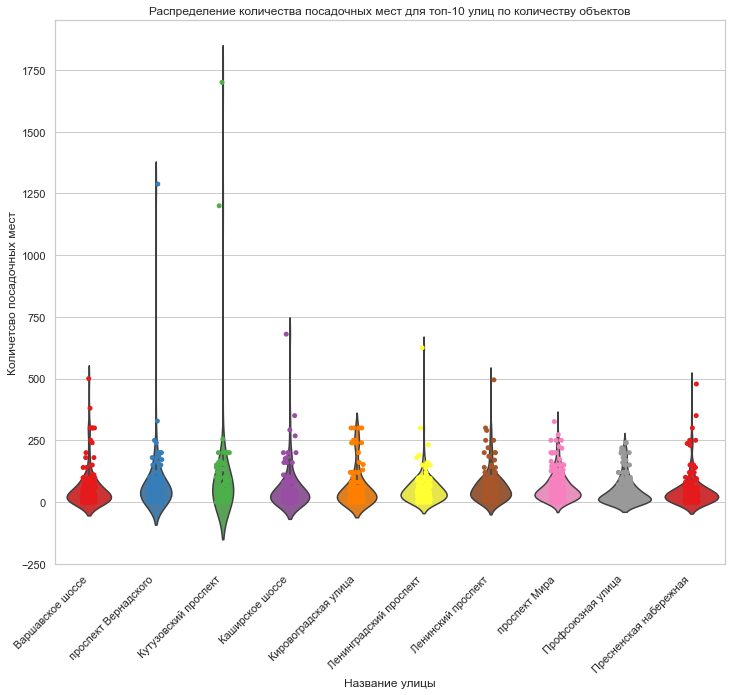

In [36]:
plt.title("Распределение количества посадочных мест для топ-10 улиц по количеству объектов")
chart = sns.violinplot(x="street", y="number", data=data.query('street in @top10_streets_names'), palette='Set1')
chart = sns.stripplot(x="street", y="number", data=data.query('street in @top10_streets_names'), palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Название улицы')
plt.ylabel("Количетсво посадочных мест")
plt.show()

Для Топ-10 улиц по колучеству объектов почти все заведения имеют до **250 мест**.

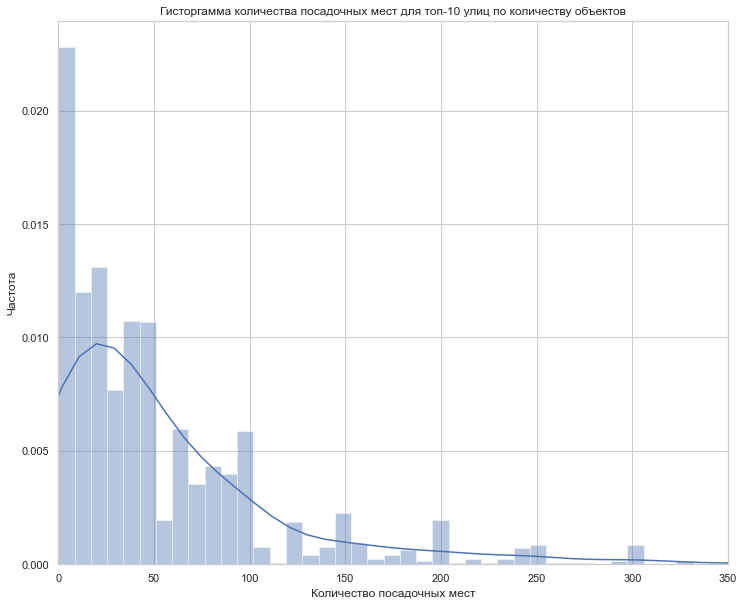

In [37]:
sns.distplot(data.query('street in @top10_streets_names')['number'], bins=200)
plt.xlim(0, 350)
plt.xlabel('Количество посадочных мест')
plt.ylabel("Частота")
plt.title("Гисторгамма количества посадочных мест для топ-10 улиц по количеству объектов")
plt.show()

Большинство объектов общепита с большим количеством объектов имеют до **100 посадочных мест**.

Видим пики на 50, 100, 150, 200, 250, 300 - хозяева заведений общественных питаний склонны выбирать число мест в заведении, **кратное 50**.

# <a id="vyvod"></a><font style="background-color: Cyan; color=black">3. Вывод по результатам исследования</font> #

Проведя исслеование по анализу рынку общественного питания в городе Москве, я могу сделать следующие выводы:

1) **Кафе популярнее всего** - они составляют около *40%* всех заведений общественного питания; следом идут столовые, рестораны и предприятия быстрого обсуживания, их *17%*, *15%* и *13%* соответственно; баров, буфетов, кафетериев, закусочных и отделов кулинариии в магазине в Москве открыто от *6% до 2%*;

2) *81%* всех заведений общественного питания - **несетевые**, *19%* - **сетевые**;

3) Так как кафе больше всего по городу, то и сетевых кафе от общего чиста сетевых предприятий больше всего -  около *50%*; для предприятий быстрого обслуживания и ресторанов также характерно сетевое распространение; для остальных видов заведений сетевое распространение редко. Наименее характерно сетевое распространение для буфета и столовой, что вполне объясняется тем, что столовая или буфет чаще всего расположены на територии какого-нибудь предприятия, которому и подчиняются;

4) Большинство сетей имеет до **20 заведений** и в них до **150 мест**;

5) Больше всего посадочных мест в столовых и ресторанах, в них в среденем от **100 до 130 мест**; далее идут буфет, бар, кафе и предприятия быстрого обслуживания, в них в среденм от **20 до 50 мест**; меньше всего мест в кафетериях, закусочных и отделах кулинарии в магазинах, в них в среденем от **5 до 10 мест**;

6) Большая часть объектов общепита находится на важнейших транспортных магистралях Москвы - проспект Мира, Профсоюзная улица, Лениградский проспект, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе - в центре на Пресненской набережной и на улице Кировоградской;

7) **533 улицы** с одним объектом общественного питания; больше всего улиц с одним объектом общественного питания находятся в районах: Таганский, Хамовники, Бассманный, Тверской и Пресненский;

8) Большая часть заведений с большим количеством объектов имеют до **100 посадочных мест**.

**Рекомендации о виде заведения, количестве посадочных мест, а также районе расположения**:

Предлагаю открыть объект общественного питания типа *кафе*, с посадочными местами до *50*. Эффективность и популярность кафе была доказана в ходе исследования. 

Учитывая, что наше заведение обладает "вау"-эффектом - гостей обслуживают роботы, такая концепция подойдет скорее молодежи. Особенно, если роботы смогут быстро варить вкусный кофе 

Открывать ресторан с нуля не выгодно - у хорошего ресторана должно быть имя, классный и известный в своих кругах повар, изысканное меню. И сама концепция ресторана предполагает наличие хостес и официантов.

Что касается района, то район **Ленинградского проспекта** был бы хорошим выбором. А именно там находится несколько университетов, бизнес-центры, концертный зал недалеко, активная жизнь (частые и известные пробки на Ленинградском шоссе могут сыграть на руку). Аренда там будет выше средней, но дешевле, чем в центре. 

# <a id="prezent"></a><font style="background-color: Cyan; color=black">4. Презентация</font> #

Ссылка на презентацию - https://yadi.sk/i/JmgsPgk1NDtBTQ